<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marco-canas/didactica_ciencia_datos/blob/main/referentes/geron/part_1/chap_3/c_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Chapter 3 Clasificación según Geron 

En el Capítulo 1 mencioné que las tareas de aprendizaje supervisado más comunes son:  

* la regresión (predicción de valores) y   
* la clasificación (predicción de clases).

En el Capítulo 2 exploramos una tarea de regresión, prediciendo los valores de la vivienda, usando varios algoritmos como 

* Regresión lineal, 
* Árboles de decisión y 
* Bosques aleatorios (Random Forest)

(que se explicarán con más detalle en capítulos posteriores). 

Ahora centraremos nuestra atención en los sistemas de clasificación.

## MNIST  

En este capítulo usaremos el conjunto de datos MNIST, que es un conjunto de 70.000 pequeñas imágenes de dígitos escritas a mano por estudiantes de secundaria y empleados de la Oficina del Censo de EE. UU.

Cada imagen está etiquetada con el dígito que representa.

Este conjunto se ha estudiado tanto que a menudo se lo llama el "hola mundo" del aprendizaje automático: cada vez que las personas crean un nuevo algoritmo de clasificación, sienten curiosidad por ver cómo funcionará en MNIST, y cualquiera que estudie el aprendizaje automático abordará este conjunto tarde o temprano.  

Scikit-Learn proporciona muchas funciones de ayuda para descargar conjuntos de datos populares.

MNIST es uno de ellos. El siguiente código obtiene el conjunto de datos MNIST

In [2]:
%%time  
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name = 'mnist_784', version=1, as_frame = False)
mnist.keys() 

CPU times: total: 34.5 s
Wall time: 35.4 s


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Los conjuntos de datos cargados por Scikit-Learn generalmente tienen una estructura de diccionario similar, que incluye lo siguiente:

* Una clave `DESCR` que describe el conjunto de datos.  
* Una clave `data` que contiene una matriz con una fila por instancia y una columna por atributo.
* Una clave `target` que contiene una matriz con las etiquetas

Veamos estas matrices:

In [3]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
type(X)

numpy.ndarray

Hay 70.000 imágenes y cada imagen tiene 784 atributos.
<img src = 'https://previews.123rf.com/images/timbrk/timbrk1501/timbrk150100052/35750727-palabra-play-de-los-amarillos-p%C3%ADxeles-cuadrados-sobre-un-fondo-negro-matriz-.jpg'>

Esto se debe a que cada imagen tiene $28 \times 28$ píxeles y cada característica simplemente representa un píxel de intensidad, de 0 (blanco) a 255 (negro).

<img src = 'https://i2.wp.com/datasmarts.net/es/wp-content/uploads/2020/07/imagematrix.png?resize=679%2C280&ssl=1'>

Echemos un vistazo a un dígito del conjunto de datos. Todo lo que necesita hacer es tomar el vector de características de una instancia, redimensionarlo a una matriz $28 \times 28$ y mostrarlo usando la función ``imshow()`` de Matplotlib:

<img src = 'https://www.geogebra.org/resource/XaBxGP4Z/k7itgEgokDkGzcgJ/material-XaBxGP4Z.png'> 

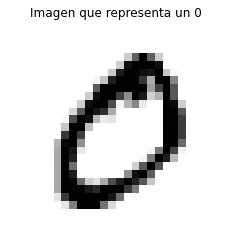

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
instancia = 1
some_digit = X[instancia]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title('Imagen que representa un {}'.format(y[instancia])) 
plt.show()

Esto parece un 5 y, de hecho, eso es lo que nos dice la etiqueta:

In [22]:
y[0]

'5'

Tenga en cuenta que la etiqueta es una cadena.

La mayoría de los algoritmos de ML esperan números, así que transformemos `y` a tipo de número entero:
    

In [6]:
import numpy as np 
y = y.astype(np.uint8) # convierte todas las entradas del vector y en enteros   

In [7]:
y[0] 

5

Para darle una idea de la complejidad de la tarea de clasificación, el siguiente código muestra algunas imágenes más del conjunto de datos MNIST.

AttributeError: module 'matplotlib.pyplot' has no attribute 'set'

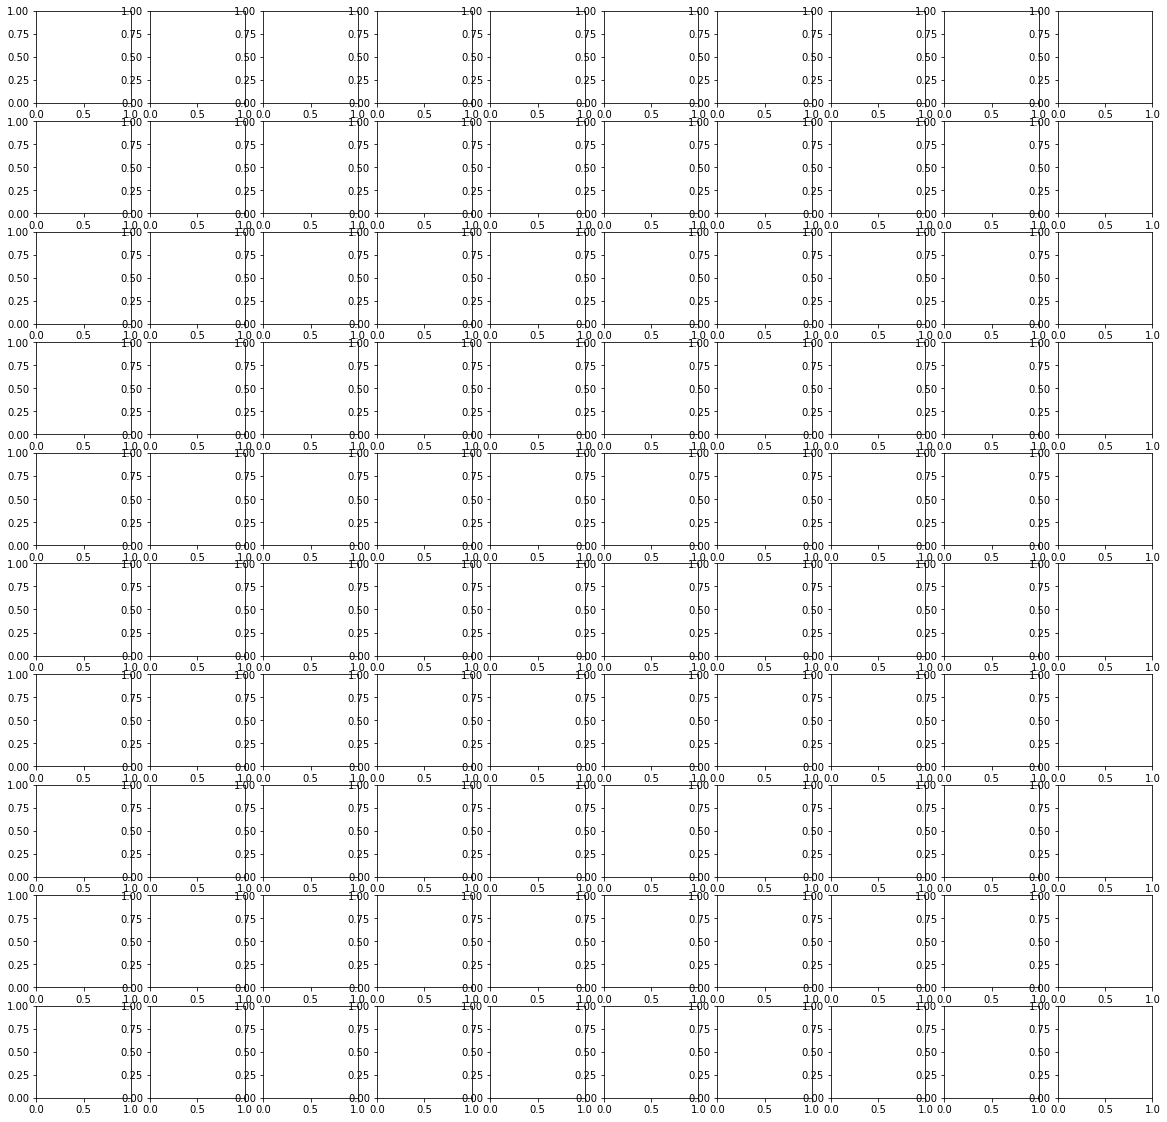

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(10,10, figsize = (20,20))

n_imagen = 0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X[n_imagen].reshape(28,28), cmap = 'binary')
        ax[i,j].axis('off') 
        n_imagen+=1

¡Pero espera! Siempre debe crear un conjunto de prueba y dejarlo a un lado antes de inspeccionar los datos de cerca. 

El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de prueba (las últimas 10.000 imágenes):

# Dividir en entrenamiento y testeo al dataset dado

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está barajado para nosotros, lo cual es bueno porque esto garantiza que todos los pliegues de validación cruzada serán similares (no desea que a un pliegue le falten algunos dígitos). 

Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y funcionan mal si obtienen muchas instancias similares seguidas. 

Mezclar el conjunto de datos garantiza que esto no suceda

## Training a Binary Classifier  

Simplifiquemos el problema por ahora e intentemos identificar solo un dígito, por ejemplo, el número 5.

Este "5-detector" será un ejemplo de un clasificador binario, capaz de distinguir entre solo dos clases,   

* 5 y 
* no 5.

Creemos los vectores objetivo para esta tarea de clasificación:

In [33]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Ahora escojamos un clasificador y entrenemoslo. 

Un buen lugar para comenzar es con un clasificador de Gradiente Descendente Estocástico (SGD), utilizando la clase `SGDClassifier` de Scikit-Learn.

Este clasificador tiene la ventaja de poder manejar conjuntos de datos muy grandes de manera eficiente.

Esto se debe en parte a que SGD se ocupa de las instancias de entrenamiento de forma independiente, una a la vez (lo que también hace que SGD sea adecuado para el aprendizaje en línea), como veremos más adelante.

Vamos a crear un `SGDClassifier` y entrenarlo en todo el conjunto de entrenamiento:

In [34]:
from sklearn.linear_model import SGDClassifier

In [35]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## Sugerencia 

El `SGDClassifier` se basa en la aleatoriedad durante el entrenamiento (de ahí el nombre "estocástico").

Si desea resultados reproducibles, debe establecer el parámetro `random_state`.

Ahora podemos usarlo para detectar imágenes del número 5:

In [36]:
sgd_clf.predict([X_train[0]])

array([ True])

El clasificador adivina que esta imagen representa un 5 (`True`). 

¡Parece que acertó en este caso particular! Ahora, evaluemos el rendimiento de este modelo.

## Performance Measures  

## Medidas de desempeño

Evaluar un clasificador suele ser significativamente más complicado que evaluar un regresor, por lo que dedicaremos gran parte de este capítulo a este tema.

Hay muchas medidas de rendimiento disponibles, ¡así que tome otro café y prepárese para aprender muchos conceptos y acrónimos nuevos!

# Medición de la exactitud mediante la validación cruzada 

Una buena forma de evaluar un modelo es utilizar **la validación cruzada**.

## IMPLEMENTING CROSS-VALIDATION  

De vez en cuando, necesitará más control sobre el proceso de validación cruzada que el que ofrece Scikit-Learn.

En estos casos, puede implementar la validación cruzada usted mismo. 

El siguiente código hace aproximadamente lo mismo que la función `cross_val_score()` de Scikit-Learn e imprime el mismo resultado:

In [41]:
%%time 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True) 
# n_splits es el número de subconjuntos en los que se dividirá el conjunto de entrenamiento
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9598333333333333
0.962
0.9421666666666667
0.9673333333333334
0.9541666666666667
CPU times: total: 1min 55s
Wall time: 1min 55s


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. 

At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold.

Luego cuenta el número de predicciones correctas y genera la proporción de predicciones correctas.

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. 

Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):

In [1]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")


NameError: name 'sgd_clf' is not defined

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? 

This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [2]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


Can you guess this model’s accuracy? Let’s find out:

In [3]:
%%time 
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


NameError: name 'X_train' is not defined

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. 

Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

# Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. 

The general idea is to count the number of times instances of class A are classified as class B. 

For example, to know the number of times the classifier confused images of 5s with 3s, you would
look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions
so that they can be compared to the actual targets. 

You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). 

Instead, you can use the `cross_val_predict()` function:

In [4]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Just like the cross_val_score() function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. 

This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. 

Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [3]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

NameError: name 'y_train_5' is not defined

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were
wrongly classified as 5s (false positives). 

The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives). 

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [2]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


NameError: name 'y_train_5' is not defined

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. 

An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier (Equation 3-1).

Equation 3-1. Precision

$$ \text{precision} = \frac{TP}{TP + FP} $$


TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). 

But this would not be very useful, since the classifier would ignore all but one positive instance. 

So precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier (Equation 3-2).

Equation 3-2. Recall  

$$ \text{recall} = \frac{TP}{TP + FN}  $$

$FN$ is, of course, the number of false negatives.

If you are confused about the confusion matrix, Figure 3-2 may help.

5

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

array([ True])

In [24]:
f()

()
{}


In [25]:
f(2,3)

(2, 3)
{}


(2, 3)
{'a': 1, 'b': 2}
